In [26]:
from tqdm import tqdm
import glob
import numpy as np
import multiprocessing as mp
from uuid import UUID
import lz4
from typing import List, Tuple, Dict, Union, Optional, Iterable
from joblib import Parallel, delayed

from pit30m.data.partitions import PreProcessPartition, GeoPartition, QueryBasePartition
from pit30m.camera import CamName
from pit30m import LogReader

%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
with open("../pit30m/all_logs.txt", "r") as f:
    logs = f.readlines()
    logs = sorted([x.strip() for x in logs])

# logs = []
# for f in glob.glob("/home/julieta/pit30m_partitions/utm_poses_dense/to_hide/*"):
# print(logs)
#     logs.append(f.split("/")[-1][:-4])

logs = logs[:10]
print(logs)

['00682fa6-2183-4a0d-dcfe-bc38c448090f', '006ce26a-cd92-4b90-ec10-454da73ede13', '009334fa-acb9-4813-c60c-1916c83974c8', '00a05077-a8f6-4f08-ee38-c7bc4e885611', '0106abc2-b689-464a-cfe4-9f6a00089733', '017be362-c6cf-47fe-e317-fdcf128ce85a', '01959149-0840-4eba-e0a0-53c6b2bb0f84', '01c3ae4e-2bb6-4bd1-efc9-bfb16e4bd1e3', '01d09d4c-329a-4952-f2ed-555aa76dab2c', '01e21524-2e61-4ea6-cf98-164bcb2d29ab']


In [28]:
def maybe_get_sensor_index(log_reader: LogReader, sensor: str, partitions=None) -> Tuple[str, Optional[np.ndarray]]:
    """Try to fetch index from AWS, return None if it doesn't exist"""    
    try:
        if sensor == "LIDAR":
            index = log_reader.get_lidar_geo_index()
        elif sensor in CamName.__members__:
            index = log_reader.get_cam_geo_index(CamName[sensor.upper()], max_delta_s=0.2, partitions=partitions)
        else:
            raise ValueError(f"Unknown sensor {sensor}")
    except FileNotFoundError:
        index = None
    
    return log_reader.log_id, index
    

def get_sensor_indices(
    log_readers: Iterable[LogReader], sensor: str, partitions = None, 
) -> Tuple[Dict[UUID, np.ndarray], Dict[UUID, LogReader], Parallel]:
    """Get the indices that map poses to sensor observations"""
    pool = Parallel(n_jobs=mp.cpu_count(), verbose=1, batch_size=8)
    res = pool(delayed(maybe_get_sensor_index)(lr, sensor, partitions) for lr in log_readers)
    sensor_indices = {log_id: index for (log_id, index) in res}
    # log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_indices, pool

In [29]:
log_readers = {}
for logid in logs:
    # log_readers[logid] = LogReader(f"s3://pit30m/{logid}/", index_version=1)
    log_readers[logid] = LogReader(
        f"s3://pit30m/{logid}/", 
        index_version=2, 
        # partitions=[PreProcessPartition.VALID, GeoPartition.TRAIN],
        # partitions=[PreProcessPartition.VALID, GeoPartition.TEST, QueryBasePartition.QUERY],
    )

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    8.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   13.2s finished


100%|██████████| 10/10 [00:00<00:00, 12945.38it/s]


4_743 poses included so far
4_743 poses included so far
4_743 poses included so far
9_233 poses included so far
9_233 poses included so far
26_312 poses included so far
37_108 poses included so far
37_108 poses included so far
37_108 poses included so far
37_108 poses included so far


100%|██████████| 10/10 [00:00<00:00, 12985.46it/s]

2_498 poses included so far
2_498 poses included so far
2_498 poses included so far
9_031 poses included so far
19_464 poses included so far
19_464 poses included so far
38_644 poses included so far
38_644 poses included so far
47_214 poses included so far
47_214 poses included so far
Total included: 47_214
Total with poses: 0
[]
[]


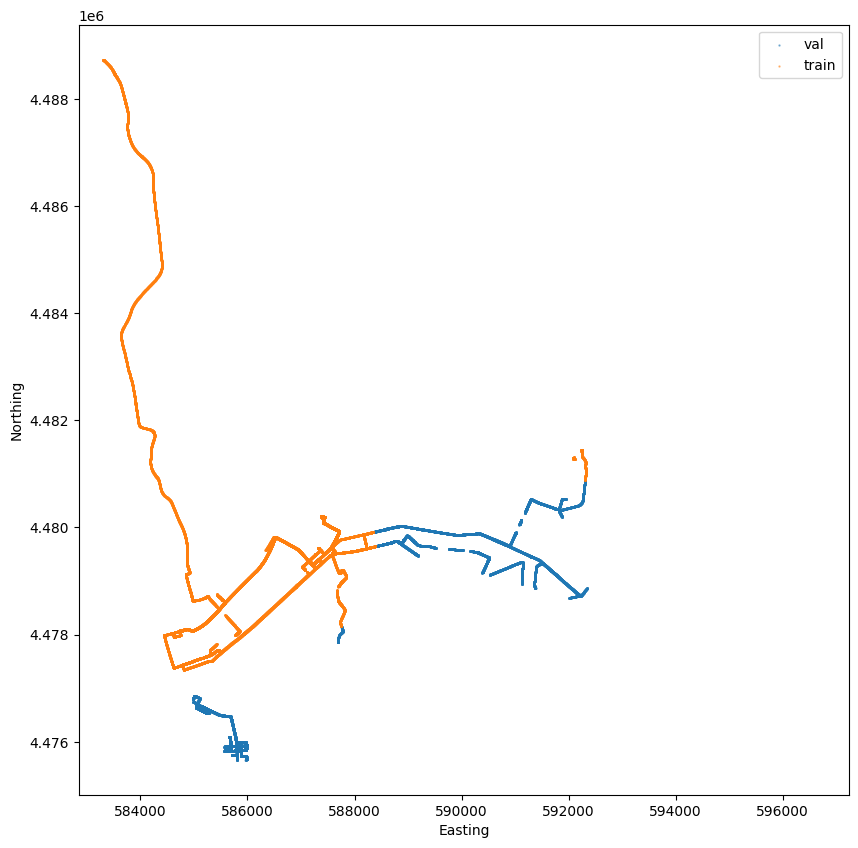

In [30]:
figsz = 20 // 2
fig = plt.figure(figsize=(figsz, figsz), dpi=100, facecolor='w', edgecolor='k')

# Load all the indices asynchronously
sensor_indices_TRAIN, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=(PreProcessPartition.VALID, GeoPartition.TRAIN),
)

sensor_indices_VAL, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=(PreProcessPartition.VALID, GeoPartition.VAL),
)

sensor_indices_TEST, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=(PreProcessPartition.VALID, GeoPartition.TEST),
)


for label, sensor_indices in zip(["val", "train", "test"], [sensor_indices_VAL, sensor_indices_TRAIN, sensor_indices_TEST]):
    
    included = 0
    with_poses = []
    missing = []
    
    xs, ys = [], []
    for log_id, index in tqdm(sensor_indices.items()):

        # camera index
        if index is None:
            print(f"{log_id} has no index yet")
            missing.append(log_id)
            continue
        
        utm_present = index["utm_present"]
        x = index["utm_x"][utm_present]
        y = index["utm_y"][utm_present]
        
        xs.append(x)
        ys.append(y)
        
        included += len(x)
        print(f"{included:_} poses included so far")
    
    x = np.concatenate(xs)
    y = np.concatenate(ys)
    sc = plt.scatter(x, y, s=0.5, alpha=0.5, label=label)

plt.axis("square")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
print(f"Total included: {included:_}")
print(f"Total with poses: {len(with_poses)}")
print(with_poses)
print(missing)